## Calculate the optimal transfer function between the transect water table depths and the interpolated HH daily data

**Inputs**
- HH daily interpolation
- Water table depth measurements

**Outputs**
- A linear transfer function that will be used to calculate the water table depth from the HH daily interpolation
- the water level timeseries derived from the linear and rainfed interpolations
- validation with water loggers statistics
- Figure 9b from the final paper

**Notes**
- previous codes used: Process_water_logger_data-new.ipynb and Calculate_WTD_backscatter_relationship.ipynb
- these codes also looked at the relationship between the water logger data and the HH daily interpolation

In [1]:
import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as goc
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
from scipy import stats
from IPython.display import display

%xmode Minimal

Exception reporting mode: Minimal


### Function declarations

In [59]:
def plot_transects_HH(df,depth_limit,HH_range, med):
    if med == True:
        # use median values
        df = df.groupby(['transect_season','date','lat','lon']).median().reset_index()
        
    df = df[df['depth']>depth_limit]
    df = df[df['HH_db'] > HH_range[0]]
    df = df[df['HH_db'] < HH_range[1]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['HH_db'],df['depth'])
    print ("Water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')

    g = sns.lmplot(x="HH_db", y="depth", hue="transect_season", data=df, fit_reg=False,legend=False, \
                   palette='colorblind', height=7)
    plt.legend()
    g.set(xlim = (-8.5,-4.5))
    sns.set_style('ticks')
    sns.regplot(x="HH_db", y="depth", data=df, scatter=False, ax=g.axes[0, 0])
    g.ax.axhline(0, ls='--',c='gray')
    db_at_zero = -intercept/slope
    print ('HH corresponding with 0 water level: ' + str(round(db_at_zero,1)) + ' db.')
    g.ax.axvline(-intercept/slope, ls='--', c='gray')
    ax = g.axes[0,0]
    g.ax.set_title("Water level = {0:.2f}$\sigma_0$ + {1:.1f}".format(slope,intercept))
    g.ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
    g.ax.set_ylabel("Water level (cm)", fontsize = 14)
    
    return(slope,intercept)

In [53]:
import scipy.stats
def plot_logger_WTD_interp(df, m_eq, c_eq, depth_limit,coords):
    # plots the logger actual and interpolated depths against datetime
    # df is the set of logger data
    # m_eq and c_eq are the transfer equation coefficients from: water level = m_eq*HH backscatter + c_eq 
    # depth limit relates to the below peat water level that we 
    # are trusting the ALOS-2 PALSAR-2 backscatter can detect changes to (RMSE will vary)
    
    df['depth_eq'] = m_eq*df['HH_db'] + c_eq
    df['depth_eq_l'] = m_eq*df['HH_db_linear'] + c_eq
    df_melt = df.melt(id_vars=['Datetime','logger','HH_db'], value_vars = ['depth','depth_eq'])
    df_melt.columns = ['Datetime','logger','HH_db','type','depth']
    df_melt
           
    # checking the correlation
    print (df.logger.unique())
    loggers = df.logger.unique()

    for i in range(len(loggers)):
        df1 = df[df['logger'] == loggers[i]]
        df1 = df1[df1['depth']>depth_limit]

        # checking the correlation
        
        # checking the correlation
        print (loggers[i] + ' correlation: ') 
        Pearsonr = scipy.stats.pearsonr(df1['depth'],df1['depth_eq'])[0]
        p_value1 = scipy.stats.pearsonr(df1['depth'],df1['depth_eq'])[1]
        
        KendallsT = scipy.stats.kendalltau(df1['depth'],df1['depth_eq'])[0]
        p_value2 = scipy.stats.kendalltau(df1['depth'],df1['depth_eq'])[1]
        
        SpearmansR = scipy.stats.spearmanr(df1['depth'],df1['depth_eq'])[0]
        p_value3 = scipy.stats.spearmanr(df1['depth'],df1['depth_eq'])[1]
        
        print ("Pearsonr: "  + str(round(Pearsonr,2)))
        print ("Pearsonr pval: " + str(round(p_value1,4)))
        print ("Kendall's \u03C4: " + str(round(KendallsT,2)))
        print ("Kendall's pval: " + str(round(p_value2,4)))
        print ("Spearman's \u03C1: " + str(round(SpearmansR,2)))
        print ("Spearman's pval: " + str(round(p_value3,4)))
        
        # adding this to the coordinates array
        #coords.loc[coords['Logger'] == loggers[i],['model corr']] = corr
        coords.loc[coords['Logger'] == loggers[i],["R2 - model"]] = round(Pearsonr**2,2)
        coords.loc[coords['Logger'] == loggers[i],['R p-value']] = p_value1
        coords.loc[coords['Logger'] == loggers[i],["Kendall's \u03C4"]] = round(KendallsT,2)
        coords.loc[coords['Logger'] == loggers[i],['\u03C4 p-value']] = p_value2
        coords.loc[coords['Logger'] == loggers[i],["Spearman's \u03C1"]] = round(SpearmansR,2)
        coords.loc[coords['Logger'] == loggers[i],['\u03C1 p-value']] = p_value3
        
        corr = np.round(df1['depth'].corr(df1['depth_eq_l']),2)
        #print (loggers[i] + ' correlation - linear: ' + str(corr))

        # checking the RMSE
        rmse_eq = ((df1.depth - df1.depth_eq) ** 2).mean() ** .5
        #print (rmse_eq)
        print (loggers[i] + ' RMSE - rainfed: ' + str(round(rmse_eq,2)) + '\n')

        rmse_eq_l = ((df1.depth - df1.depth_eq_l) ** 2).mean() ** .5
        #print (rmse_eq)
        print (loggers[i] + ' RMSE - linear: ' + str(round(rmse_eq_l,2)) + '\n')
        
        # plotting the graphs
        grid = sns.FacetGrid(data=df_melt,col='logger',hue='type',col_wrap=3, size=4, legend_out=True)

        #grid.refline(y=0, linestyle = ':')
        grid.map(plt.plot,'Datetime','depth')
        grid.set(xlim=(start_date,df['Datetime'][-1:]))
        #grid.set(ylim=(-30,30))
        grid.fig.tight_layout(w_pad=2)
        grid.set_axis_labels(y_var = 'Water level (cm)', x_var = '')

        # setting the individual sub-plot titles to the loggers array names

        grid.set_titles(template='{col_name}')

        # Add a horizontal line at y=0
        #plt.hlines(y=0, xmin=start_date, xmax=df['Datetime'][-1:], color='black', linestyle=':')
        labels = ['Logger water level', 'Modelled water level']

        # Get the handles and labels for the legend
        handles, _ = plt.gca().get_legend_handles_labels()

        # Create the legend
        plt.legend(handles, labels, title='')

        # rotating the datetime x axis labels
        for ax in grid.axes.flat:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            #ax.annotate('test',xy=(0.1,0.95))
            # Add a horizontal line at y=0
            ax.axhline(y=0, color='black', linestyle=':')


        # adding a y = 0 line to signify the water level being at peat surface
        #grid.refline(y=0, linestyle = ':')

        plt.show()
    
    return (coords)


In [9]:
def convert_to_WL(da, m, c, filename):
    # uses the transect water depth linear regression values to calculate the final timeseries of water level values
    # can be applied for a single location or for the full image area
    print ('Calculting the water level...')
    da2 = da*m + c
    
    print ('Converting to dataset...')
    ds = da2.to_dataset(name='water_level') 
    
    print ('Saving to netcdf...')
    ds.to_netcdf(ALOS_OUT + filename)
    return (ds)

### Main code

In [2]:
### Declare data and output directories here:

# ALOS_OUT = 


In [3]:
# daily ALOS-2 HH data

# version interpolated using NW input
# m-grid
#HH_daily_ds_m = xr.open_dataset(ALOS_OUT + 'HH_daily_m_grid_nearest_full_ts_all.nc')

# the final daily interpolated data (using the forwards and backwards m-grid interpolations - interpolate to daily3 function output)
#HH_daily_fb = xr.open_dataset(ALOS_OUT + 'HH_daily_mgrid_all_weighted.nc')
#HH_daily_fb = xr.open_dataset(ALOS_OUT + 'HH_daily_mgrid_all_weighted_logistic_FULL.nc')  # no pw_corr threshold
HH_daily_fb = xr.open_dataset(ALOS_OUT + 'HH_daily_mgrid_all_weighted_logistic.nc')  # pw_corr threshold < 0.15

# the original gradients dataset (not masked for p<0.05)
gradients_peat2 = xr.open_dataset(ALOS_OUT + 'slopes_da_HH_new.nc')
test = gradients_peat2.to_array().to_dataset(name='gradient')
gradients_peat_all = test['gradient'][0][0].to_dataset(name='gradient')

# linear interpolation
HH_daily_ds_l = xr.open_dataset(ALOS_OUT + 'HH_linear_full_ts.nc')

# combined linear and rainfed (interpolate_to_daily2 function output)
#HH_daily = xr.open_dataset(ALOS_OUT + 'HH_daily_final.nc')

start_date = HH_daily_ds_l['time'][0]
end_date = HH_daily_ds_l['time'][-1]
print (np.array(start_date),np.array(end_date))

# HH data - 17 timesteps for area 2
HH_db_100m = xr.open_dataset(ALOS_OUT + 'HH_db_100m_area2.nc')

# transect data
transects_orig = pd.read_csv(GHG + 'Transect_CH4_fluxes2.csv')

# net water data
nw_daily_100m = xr.open_dataset(ALOS_OUT + 'nw_daily_new_100m.nc')
nw_daily_100m

# water loggers - the original version with anomalous data - Bart 
DRC_loggers = pd.read_csv(GHG + 'loggers.csv')

# water loggers - the new version that Bart sent May 2022
#loggers = pd.read_csv(GHG + 'loggers2.csv')

# Ekolongouma logger data (median values)
EKG02 = pd.read_csv(GHG + 'EKG02.csv')
EKG03 = pd.read_csv(GHG + 'EKG03.csv')

# Ekolongouma sub-hourly data (use this to extract the 10:40am values)
EKG02_1040 = pd.read_csv(GHG + 'EKG02_1040.csv')
EKG03_1040 = pd.read_csv(GHG + 'EKG03_1040.csv')

# land type map
lt_map = xr.open_dataset(ALOS_OUT + 'landtype_100m.nc')

# pixel wise correlation slope data
pw_slopes = xr.open_dataset(ALOS_OUT + 'slopes_da_HH_new.nc')
test = pw_slopes.to_array().to_dataset(name='slope')
pw_slopes = test['slope'][0][0].to_dataset(name='slope')
pw_slopes = pw_slopes.where(lt_map['type'].isin([4,5]))
pw_slopes = pw_slopes.drop('variable')

# 2. correlations
pw_corrs = xr.open_dataset(ALOS_OUT + 'corrs_da_HH_new.nc')
test = pw_corrs.to_array().to_dataset(name='correlation')
pw_corrs = test['correlation'][0][0].to_dataset(name='correlation')
pw_corrs = pw_corrs.where(lt_map['type'].isin([4,5]))
pw_corrs = pw_corrs.drop('variable')

# 3. p-values
pw_pvals = xr.open_dataset(ALOS_OUT + 'pvals_da_HH_new.nc')
test = pw_pvals.to_array().to_dataset(name='pvalue')
pw_pvals = test['pvalue'][0][0].to_dataset(name='pvalue')
pw_pvals = pw_pvals.where(lt_map['type'].isin([4,5]))
pw_pvals = pw_pvals.drop('variable')

# 4. standard errors
pw_stderrs = xr.open_dataset(ALOS_OUT + 'stderrs_da_HH_new.nc')
test = pw_stderrs.to_array().to_dataset(name='stderr')
pw_stderrs = test['stderr'][0][0].to_dataset(name='stderr')
pw_stderrs = pw_stderrs.where(lt_map['type'].isin([4,5]))
pw_stderrs = pw_stderrs.drop('variable')

2019-03-29T00:00:00.000000000 2020-10-08T00:00:00.000000000


In [ ]:
# opening the pixel wise correlation data
pw_corrs = xr.open_dataset(ALOS_OUT + 'corrs_da_HH_new.nc')
test = pw_corrs.to_array().to_dataset(name='correlation')
pw_corrs = test['correlation'][0][0].to_dataset(name='correlation')
#pw_corrs = pw_corrs.where(lt_map['type'].isin([4,5]))
pw_corrs = pw_corrs.drop('variable')
pw_corrs

In [6]:
# transect data
transects_orig = pd.read_csv(GHG + 'Transect_CH4_fluxes.csv')

## Processing water table depth measurements 
- colocated with GHG flux measurements
- combine these with the median logger measurements
- test combining them with the 10:40 measurements as they would all have been taken during daylight hours and may correspond better with the 10:40 data.

In [10]:
# reorganising the transects dataframe
transects = transects_orig.copy()
transects.rename(columns = {'Latitude':'lat','Longitude':'lon','WTD_corrected':'depth'}, inplace = True)
transects['datetime'] = pd.to_datetime(transects['date'], dayfirst=True)
transects = transects [['datetime','date','lat','lon','transect_season','season','km_number','depth','CH4_mg']]
transects = transects.sort_values(by=['transect_season','datetime']).reset_index(drop=True)
transects = transects.dropna(subset=['depth','CH4_mg']).reset_index()
transects

,index,datetime,date,lat,lon,transect_season,season,km_number,depth,CH4_mg
0,1,2020-01-26,26/01/2020,1.453788,18.899030,Boboka-dry,dry,0,-3.0,26.2
1,2,2020-01-26,26/01/2020,1.453788,18.899030,Boboka-dry,dry,0,-5.0,26.2
2,4,2020-01-26,26/01/2020,1.453788,18.899030,Boboka-dry,dry,0,9.5,29.3
3,5,2020-01-27,27/01/2020,1.467406,18.887550,Boboka-dry,dry,2,-37.0,3.5
4,7,2020-01-27,27/01/2020,1.467406,18.887550,Boboka-dry,dry,2,-2.0,20.5
...,...,...,...,...,...,...,...,...,...,...
352,402,2020-10-23,23/10/2020,-0.140653,18.916243,Mpeka-wet,wet,9,-3.0,0.0
353,403,2020-10-23,23/10/2020,-0.140653,18.916243,Mpeka-wet,wet,9,-2.0,0.0
354,404,2020-10-23,23/10/2020,-0.140653,18.916243,Mpeka-wet,wet,9,-3.0,0.5
355,405,2020-10-23,23/10/2020,-0.140653,18.916243,Mpeka-wet,wet,9,0.2,10.5


In [ ]:
%%time
# Extracting backscatter HH values

# adding a column with the nearest HH backscatter rainfed interpolation value
transects['HH_db'] = np.nan


# 15 image ALOS-2 timeseries
#transects['HH_db_orig'] = np.nan

# linearly interpolated backscatter values, for comparison with the daily interpolated ones using the net water input
transects['HH_db_linear'] = np.nan

for i in range(len(transects)):
    #print (i)
    dt1 = transects['datetime'][i]
    lat1 = transects['lat'][i]
    lon1 = transects['lon'][i]
    transects['HH_db'][i] = HH_daily_fb['db'].sel(time=dt1,lon=lon1,lat=lat1,method='nearest')
    transects['HH_db_linear'][i] = HH_daily_ds_l['db'].sel(time=dt1,lon=lon1,lat=lat1,method='nearest')
    #transects['HH_db_orig'][i] = HH_db_100m['db'].sel(time=dt1,lon=lon1,lat=lat1, method='nearest')
    
# some HH_db values are nan due to there not being close values for extraction - removing these
transects = transects.dropna()

transects

In [39]:
transects['transect_season'].unique()

array(['Boboka-dry', 'Bondzale-dry', 'Ekolongouma-dry', 'Ikelamba-dry',
       'Ipombo-dry', 'Ipombo-wet', 'Itanga-dry', 'Lokolama-wet',
       'Mpeka-dry', 'Mpeka-wet'], dtype=object)

Water level = 7.47HH + 53.67
R = 0.476, p value = 7.203e-07, std error = 1.409 cm
HH corresponding with 0 water level: -7.2 db.


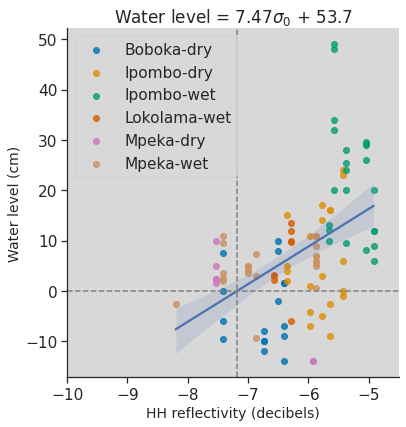

In [20]:
# Plotting transects depth vs HH
df = transects.copy()

# The backscatter can't resolve water changes deeper than 15 cm well, and below -35cm there is saturation of the backscatter at around -8dB
# Applying -15 cm as the depth limit - additional data would help to better establish this.
depth_limit = -15
slope, intersect = plot_transects_HH(df,depth_limit, [-9,-4], med = False)

In [ ]:
# transects data
transects_orig = pd.read_csv('/home/s0677837/Datastore/PHD/GHG/' + 'Transect_CH4_fluxes.csv')

coords  = transects_orig[['transect_season','Latitude','Longitude']].groupby(['transect_season']).mean().reset_index()
#coords['colours'] = ['blue','orange',]
print (coords)

# selecting only the final transects that were used in the regression
coords = coords[coords['transect_season'].isin(['Boboka-dry', 'Ipombo-dry', 'Ipombo-wet', 'Lokolama-wet','Mpeka-dry','Mpeka-wet'])].reset_index(drop=True)
coords['colours'] = ['blue','yellow','green','#FF5733','#c9a4a0','#d24787']
print (coords)

# text to be annotated

coords_txt = coords.copy()
coords_txt = coords_txt[coords_txt['transect_season'].isin(['Boboka-dry','Ipombo-wet','Lokolama-wet','Mpeka-wet'])].reset_index(drop=True)
coords_txt['transect_season'] = ['Boboka (dry)','Ipombo (dry + wet)','Lokolama (wet)','Mpeka (dry + wet)']
coords_txt['Latitude'] = coords_txt['Latitude']+0.07
coords_txt['Longitude'] = coords_txt['Longitude']-0.3
coords_txt.loc[2,'Latitude'] = list(coords_txt[coords_txt['transect_season']=='Lokolama (wet)']['Latitude']-0.19)[0]
coords_txt


<ipython-input-18-dd84bf38f17a>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labelsx)
<ipython-input-18-dd84bf38f17a>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labelsy)


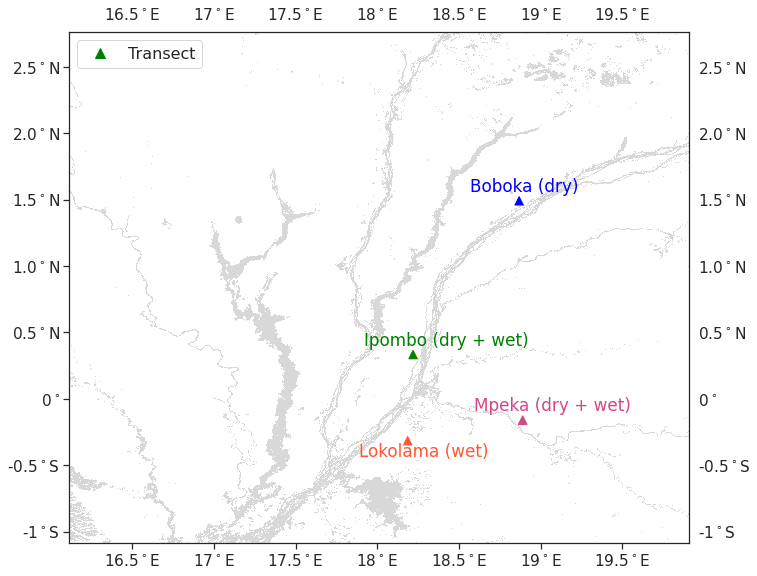

In [18]:
# plotting a map with the transect locations

from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import Patch

import matplotlib.lines as mlines

colors = ['#d8d8d8',
          '#d8d8d8',
          '#d8d8d8',
          '#fff',
          '#fff']


cmap = ListedColormap(colors)

class_bins = [0.5,1.5,2.5,3.5,4.5,5.5]
#class_bins = [0,1,2,3,4,5,6,7]

norm = BoundaryNorm(class_bins,
                    len(colors))
sns.set(font_scale=1.4, style="ticks",rc={'axes.facecolor':'#d8d8d8'})
fig, ax = plt.subplots(figsize=(11.1, 9.4))
im = lt_map.type.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)

# Add a legend for labels
legend_labels = {colors[4]:"peat swamp"}

colors = ['green']
markers = ['^']
legend_labels = {colors[0]: "Transect" }
patches = [Patch(color=color, label=label,)
           for color, label in legend_labels.items()]
#ax.set_xlim(16.0,19.5)

transect_tri = mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          markersize=10, label='Transect')

plt.legend(handles=[transect_tri],loc='upper left',frameon=True,
          facecolor="white",prop={'size': 16.0})

    
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

# adding 2nd axes labels
ax.tick_params(labeltop=True, labelright=True)
    
# adding the transect location points 
ax.scatter(coords.Longitude, coords.Latitude, zorder=1, alpha= 1., c=coords['colours'], s=70, marker='^')

# annotating
for i, txt in enumerate(coords_txt['transect_season']):
    plt.annotate(txt, (coords_txt['Longitude'][i], coords_txt['Latitude'][i]), color=coords_txt['colours'][i])

    

labelsx=['0','16.5$^\circ$E','17$^\circ$E','17.5$^\circ$E','18$^\circ$E','18.5$^\circ$E','19$^\circ$E',\
         '19.5$^\circ$E']
ax.set_xticklabels(labelsx)

# turning off x and y label titles
x_axis = ax.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

y_axis = ax.axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)


labelsy=['0','-1$^\circ$S','-0.5$^\circ$S','0$^\circ$','0.5$^\circ$N','1.0$^\circ$N','1.5$^\circ$N', \
         '2.0$^\circ$N','2.5$^\circ$N'] 
ax.set_yticklabels(labelsy)
#ax.set_axis_off()
plt.title('')
plt.show()


In [22]:
# Investigating the wet and dry season regressions seperately
wet_list = ['Ipombo-wet','Lokolama-wet','Mpeka-wet']
dry_list = ['Boboka-dry','Bondzale-dry','Ekolongouma-dry','Ikelamba-dry','Ipombo-dry','Itanga-dry','Lobaka-dry','Mpeka-dry']

df_wet = df[df['transect_season'].isin(wet_list)]
df_dry = df[df['transect_season'].isin(dry_list)]

slope, intercept, r_value, p_value, std_err = stats.linregress(df_dry['HH_db'],df_dry['depth'])

print (" Dry transects water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')

slope, intercept, r_value, p_value, std_err = stats.linregress(df_wet['HH_db'],df_wet['depth'])

print (" Wet transects water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')


 Dry transects water level = 17.8HH + 97.57
R = 0.511, p value = 1e-10, std error = 2.522 cm
 Wet transects water level = 8.46HH + 63.04
R = 0.559, p value = 9.1e-06, std error = 1.724 cm


### Median depth at each location along the transects
- This is the final equation used

Water level = 7.45HH + 53.23
R = 0.594, p value = 0.0027877377, std error = 2.2 cm


Text(0, 0.5, 'Water depth (cm)')

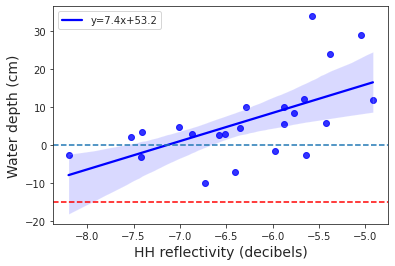

In [20]:
# grouping and averaging depths by transect_season (transect name) and date- there is a lot of variation 
df = transects.copy()

df = df.groupby(['transect_season','date','lat','lon']).median().reset_index()

# Depth limit of 15 cm below the peat surface
depth_T = -15
df = df[df['depth']>depth_T]
slope, intercept, r_value, p_value, std_err = stats.linregress(df['HH_db'],df['depth'])

print ("Water level = " + str(round(slope,2)) +'HH + ' +str(round(intercept,2)) + '\nR = ' + str(round(r_value,3)) +', p value = ' +str(round(p_value,10)) + ', std error = ' + str(round(std_err,3)) + ' cm')
# use line_kws to set line label for legend
ax = sns.regplot(x="HH_db", y="depth", data=df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.axhline(0, ls='--')
ax.axhline(depth_T, ls='--',c='r')
# plot legend
ax.legend()
ax.set_xlabel('HH reflectivity (decibels)', fontsize = 14)
ax.set_ylabel("Water depth (cm)", fontsize = 14)


Water level = 7.45HH + 53.23
R = 0.594, p value = 0.0027877377, std error = 2.2 cm
HH corresponding with 0 water level: -7.1 db.
7.4485365358649505 53.22919819124438


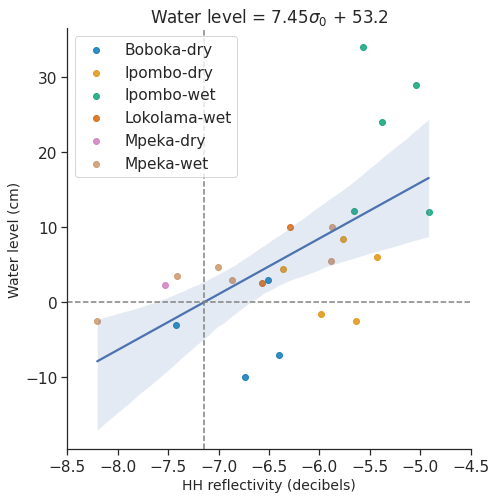

In [60]:
# Making the above plot more descriptive
df = transects.copy()
depth_limit = -15
slope, intercept = plot_transects_HH(df,depth_limit,[-12,0],med=True)
print (slope,intercept)

## Validation with logger timeseries/statistics

In [46]:
# Logger coordinates
# creating a dataframe with the DRC logger coordinates
data = [['LOK5_1.0',-0.30320, 18.20069],['LOK5_3.0', -0.31495, 18.18710],['LOK5_4.0', -0.32095, 18.18046],['IKE1_5.0',  0.28348, 18.82755]]
data = [['LOK5_1.0',-0.30320, 18.20069],['LOK5_3.0', -0.31495, 18.18710],['LOK5_4.0', -0.31795, 18.18378]]

l_coords = pd.DataFrame(data, columns = ['Logger','lat','lon'])

# creating a dataframe with the RoC logger coordinates
data = [['EKG02',1.191986,17.84694 ],['EKG03',1.188695 , 17.83192]]
EKG_coords = pd.DataFrame(data, columns = ['Logger','lat','lon'])

# Combining these two sets of coords
coords = pd.concat([l_coords, EKG_coords], axis = 0).reset_index(drop=True)

# extracting pw correlation information at each coord
coords['R2'] = np.nan
coords['p-value'] = np.nan
coords['slope (cm/dB)'] = np.nan
coords['std error (cm)'] = np.nan
coords['R2 - model'] = np.nan
coords["Pearson's R p-value"] = np.nan
coords["Kendall's \u03C4"] = np.nan
coords['\u03C4 p-value'] = np.nan
coords["Spearman's \u03C1"] = np.nan
coords['\u03C1 p-value'] = np.nan

pw_corrs2 = pw_corrs.copy()

for i, row in coords.iterrows():
    coords.at[i, 'R2'] = np.round((pw_corrs.sel(lon=row['lon'],lat=row['lat'],method='nearest')['correlation'])**2,2)

    coords.at[i, 'p-value'] = np.round(pw_pvals.sel(lon=row['lon'],lat=row['lat'],method='nearest')['pvalue'],2)
    coords.at[i, 'slope (cm/dB)'] = np.round(pw_slopes.sel(lon=row['lon'],lat=row['lat'],method='nearest')['slope']/10.,2)
    coords.at[i, 'std error (cm)'] = np.round(pw_stderrs.sel(lon=row['lon'],lat=row['lat'],method='nearest')['stderr']/10.0,2)

coords


,Logger,lat,lon,R2,p-value,slope (cm/dB),std error (cm),R2 - model,Pearson's R p-value,Kendall's τ,τ p-value,Spearman's ρ,ρ p-value
0,LOK5_1.0,-0.303200,18.20069,0.25,0.04,6.65,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1,LOK5_3.0,-0.314950,18.18710,0.10,0.14,3.93,3.45,NaN,NaN,NaN,NaN,NaN,NaN
2,LOK5_4.0,-0.317950,18.18378,0.07,0.18,4.15,4.28,NaN,NaN,NaN,NaN,NaN,NaN
3,EKG02,1.191986,17.84694,0.37,0.01,7.53,2.85,NaN,NaN,NaN,NaN,NaN,NaN
4,EKG03,1.188695,17.83192,0.28,0.03,5.28,2.45,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# The EKG_loggers_1040_df.feather file is output from Process_water_logger_data-new.ipynb
df = pd.read_feather(ALOS_OUT + 'EKG_loggers_1040_df.feather')
df = df[df['Datetime']<'2020-01-01']

# median transect values
print (slope,intercept)

coords_new = plot_logger_WTD_interp(df,slope,intercept,-15,coords)
coords_new

7.4485365358649505 53.22919819124438
['EKG02' 'EKG03']
EKG02 correlation: 
Pearsonr: 0.64
Pearsonr pval: 0.0
Kendall's τ: 0.45
Kendall's pval: 0.0
Spearman's ρ: 0.63
Spearman's pval: 0.0
EKG02 RMSE - rainfed: 13.77

EKG02 RMSE - linear: 13.56

EKG03 correlation: 
Pearsonr: 0.75
Pearsonr pval: 0.0
Kendall's τ: 0.53
Kendall's pval: 0.0
Spearman's ρ: 0.73
Spearman's pval: 0.0
EKG03 RMSE - rainfed: 5.53

EKG03 RMSE - linear: 4.85



,Logger,lat,lon,R2,p-value,slope (cm/dB),std error (cm),R2 - model,Pearson's R p-value,Kendall's τ,τ p-value,Spearman's ρ,ρ p-value,R p-value
0,LOK5_1.0,-0.303200,18.20069,0.25,0.04,6.65,3.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LOK5_3.0,-0.314950,18.18710,0.10,0.14,3.93,3.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LOK5_4.0,-0.317950,18.18378,0.07,0.18,4.15,4.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EKG02,1.191986,17.84694,0.37,0.01,7.53,2.85,0.41,NaN,0.45,1.943098e-30,0.63,1.143362e-32,1.205255e-34
4,EKG03,1.188695,17.83192,0.28,0.03,5.28,2.45,0.56,NaN,0.53,7.396738e-38,0.73,3.068953e-45,1.259613e-47


In [55]:
df = pd.read_feather(ALOS_OUT + 'DRC_loggers_1040_df.feather')
df = df[df['logger'].isin(['LOK5_1.0','LOK5_3.0','LOK5_4.0'])]

print (slope, intercept)

# median transect values
coords_new = plot_logger_WTD_interp(df,slope,intercept,-15,coords_new)
coords_new

7.4485365358649505 53.22919819124438
['LOK5_1.0' 'LOK5_3.0' 'LOK5_4.0']
LOK5_1.0 correlation: 
Pearsonr: 0.47
Pearsonr pval: 0.0
Kendall's τ: 0.32
Kendall's pval: 0.0
Spearman's ρ: 0.47
Spearman's pval: 0.0
LOK5_1.0 RMSE - rainfed: 8.55

LOK5_1.0 RMSE - linear: 8.75

LOK5_3.0 correlation: 
Pearsonr: 0.58
Pearsonr pval: 0.0
Kendall's τ: 0.4
Kendall's pval: 0.0
Spearman's ρ: 0.6
Spearman's pval: 0.0
LOK5_3.0 RMSE - rainfed: 7.29

LOK5_3.0 RMSE - linear: 7.2

LOK5_4.0 correlation: 
Pearsonr: 0.51
Pearsonr pval: 0.0
Kendall's τ: 0.35
Kendall's pval: 0.0
Spearman's ρ: 0.53
Spearman's pval: 0.0
LOK5_4.0 RMSE - rainfed: 7.44

LOK5_4.0 RMSE - linear: 6.85



,Logger,lat,lon,R2,p-value,slope (cm/dB),std error (cm),R2 - model,Pearson's R p-value,Kendall's τ,τ p-value,Spearman's ρ,ρ p-value,R p-value
0,LOK5_1.0,-0.303200,18.20069,0.25,0.04,6.65,3.35,0.22,NaN,0.32,1.253132e-14,0.47,2.781933e-15,2.833107e-15
1,LOK5_3.0,-0.314950,18.18710,0.10,0.14,3.93,3.45,0.34,NaN,0.40,2.157807e-21,0.60,4.373356e-26,4.212143e-24
2,LOK5_4.0,-0.317950,18.18378,0.07,0.18,4.15,4.28,0.26,NaN,0.35,2.766171e-16,0.53,1.048927e-19,1.291394e-17
3,EKG02,1.191986,17.84694,0.37,0.01,7.53,2.85,0.41,NaN,0.45,1.943098e-30,0.63,1.143362e-32,1.205255e-34
4,EKG03,1.188695,17.83192,0.28,0.03,5.28,2.45,0.56,NaN,0.53,7.396738e-38,0.73,3.068953e-45,1.259613e-47


In [56]:
coords_new

,Logger,lat,lon,R2,p-value,slope (cm/dB),std error (cm),R2 - model,Pearson's R p-value,Kendall's τ,τ p-value,Spearman's ρ,ρ p-value,R p-value
0,LOK5_1.0,-0.303200,18.20069,0.25,0.04,6.65,3.35,0.22,NaN,0.32,1.253132e-14,0.47,2.781933e-15,2.833107e-15
1,LOK5_3.0,-0.314950,18.18710,0.10,0.14,3.93,3.45,0.34,NaN,0.40,2.157807e-21,0.60,4.373356e-26,4.212143e-24
2,LOK5_4.0,-0.317950,18.18378,0.07,0.18,4.15,4.28,0.26,NaN,0.35,2.766171e-16,0.53,1.048927e-19,1.291394e-17
3,EKG02,1.191986,17.84694,0.37,0.01,7.53,2.85,0.41,NaN,0.45,1.943098e-30,0.63,1.143362e-32,1.205255e-34
4,EKG03,1.188695,17.83192,0.28,0.03,5.28,2.45,0.56,NaN,0.53,7.396738e-38,0.73,3.068953e-45,1.259613e-47


### Table version included in the final paper

In [57]:
print (coords_new.to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
   Logger &       lat &       lon &    R2 &  p-value &  slope (cm/dB) &  std error (cm) &  R2 - model &  Pearson's R p-value &  Kendall's τ &     τ p-value &  Spearman's ρ &     ρ p-value &     R p-value \\
\midrule
 LOK5\_1.0 & -0.303200 &  18.20069 &  0.25 &     0.04 &           6.65 &            3.35 &        0.22 &                  NaN &         0.32 &  1.253132e-14 &          0.47 &  2.781933e-15 &  2.833107e-15 \\
 LOK5\_3.0 & -0.314950 &  18.18710 &  0.10 &     0.14 &           3.93 &            3.45 &        0.34 &                  NaN &         0.40 &  2.157807e-21 &          0.60 &  4.373356e-26 &  4.212143e-24 \\
 LOK5\_4.0 & -0.317950 &  18.18378 &  0.07 &     0.18 &           4.15 &            4.28 &        0.26 &                  NaN &         0.35 &  2.766171e-16 &          0.53 &  1.048927e-19 &  1.291394e-17 \\
    EKG02 &  1.191986 &  17.84694 &  0.37 &     0.01 &           7.53 &            2.85 &        0.41 &                

## Converting the full stack of HH daily images to water level 

In [122]:
%%time
# Creating the final interpolated water level series across all image dates using these slope and intercept values
print (slope, intercept)
ds1 = convert_to_WL(HH_daily_fb['db'], slope, intercept, 'HH_modelled_water_level_ts.nc')

7.4485365358649505 53.22919819124438
Calculting the water level...
Converting to dataset...
Saving to netcdf...
CPU times: user 8.52 s, sys: 2min 7s, total: 2min 15s
Wall time: 3min 48s


In [123]:
%%time
# Likewise, applying the same equation to the linear interpolation
print (slope, intercept)
ds2 = convert_to_WL(HH_daily_ds_l['db'], slope, intercept, 'HH_linear_water_level_ts.nc')

7.4485365358649505 53.22919819124438
Calculting the water level...
Converting to dataset...
Saving to netcdf...
CPU times: user 22 s, sys: 11min 10s, total: 11min 32s
Wall time: 13min 28s
